In [1]:
import os
import tensorflow as tf
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import pandas as pd
from keras.utils import generic_utils

2022-09-30 13:25:18.465908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-30 13:25:18.568995: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-30 13:25:18.593684: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-30 13:25:19.043259: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Load Model

In [3]:
#load model
from tensorflow.keras.models import load_model

model_dir ='/media/tohn/SSD/ModelEfficientV2/Model_effnetV2M_5ClassOV/efficientnetV2M_5ClassOV.h5'
model = load_model(model_dir)
height = width = model.input_shape[1]

2022-09-30 13:30:12.049542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-30 13:30:12.441169: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9454 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


# DATA

In [6]:
#Train
dataframe = pd.read_csv('/media/tohn/HDD/VISION_dataset/DATA_OVRDT/CSV/azure_ovrdtDB_Alllevel_1200imgs_round1_train.csv')
dataframe['class'] = dataframe['class'].astype(str)
print(dataframe.shape)
dataframe.head()

#validation
valframe = pd.read_csv('/media/tohn/HDD/VISION_dataset/DATA_OVRDT/CSV/azure_ovrdtDB_Alllevel_300imgs_round1_test.csv') #เปลี่ยนตาม fold
valframe['class'] = valframe['class'].astype(str)
print(valframe.shape)
valframe.head()

DATA_PATH = "/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrdtDB_08_06_65_from_AjOP_labeled/ovrdtDB_1"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
validation_dir = os.path.join(DATA_PATH, 'validation')
print(validation_dir)

(1200, 10)
(300, 10)
/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrdtDB_08_06_65_from_AjOP_labeled/ovrdtDB_1/train
/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrdtDB_08_06_65_from_AjOP_labeled/ovrdtDB_1/validation


In [7]:
#Setting data loader
batch_size = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=[0.5,1.5],
      shear_range=0.4,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
        dataframe = valframe,
        directory = train_dir,
        x_col = 'path',
        y_col = 'class',
        target_size = (height, width),
        batch_size=batch_size,
        color_mode= 'rgb',
        class_mode='categorical')

#label
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 300 validated image filenames belonging to 6 classes.
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}


## Predict Step

In [8]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    return result[0]

#Predict
pred_list = list()
prob_list = list()
img_path=valframe['path'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    result = np.argmax(predict)
    pred_list.append(labels[result])
    prob_list.append(predict[result])

2022-09-30 13:35:46.132764: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-09-30 13:35:46.480008: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 69ms/step


In [10]:
img = image.load_img(valframe['path'][299], target_size=(height, width))
# Convert it to a Numpy array with target shape.
x = image.img_to_array(img)
# Reshape
x = x.reshape((1,) + x.shape)
x /= 255.
result = model.predict([x])
result

1/1 [==============================] - 0s 41ms/step


array([[0.13482006, 0.11764447, 0.20873316, 0.30815226, 0.07259012,
        0.15805997]], dtype=float32)

In [9]:
valframe['category_ov'] = pred_list
valframe['Prob_ov'] = prob_list
valframe

,Unnamed: 0,fileName,class,path,path_filename,ov_level,ov,path_crop,OSofRec,data,category_ov,Prob_ov
0,15,binzpovayv.png.jpg,0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,1.0,1.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,Android,train,0,0.346293
1,20,aeetooklxt.png.jpg,0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,0.0,0.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,Android,train,2,0.289602
2,21,axycvnaxjp.png.jpg,0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,0.0,0.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,Android,train,3,0.336168
3,24,dozunkkhvm.png.jpg,0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,0.0,0.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,Android,train,1,0.664884
4,25,dtmvydboay.png.jpg,0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,0.0,0.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,Android,train,1,0.242216
...,...,...,...,...,...,...,...,...,...,...,...,...
295,2402,1A79E1C1-AF83-4D81-A356-CF9567B5DCEB.jpg,5,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,2.0,1.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,IOS,train,5,0.439154
296,2409,8AA19737-E676-47F1-81D3-64F991BC6D86.jpg,5,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,3.0,1.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,IOS,train,3,0.217270
297,2419,8F84D14E-B476-4780-869C-5E7960D884B6.jpg,5,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,1.0,1.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,IOS,train,5,0.503071
298,2422,6C48D8C8-2CF0-44B6-8699-F04BD3B6C0B4.jpg,5,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,2.0,1.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,IOS,train,5,0.425757


In [13]:
data_train = valframe
#เช็คคลาสใน Predicted
pred_class = set(data_train['category_ov'])
print('Predicted : ',len(pred_class))
print(pred_class)
print('-'*50)
#เช็คคลาสใน Actual
classe = set(data_train['class'])
print('Actual : ',len(classe))
print(classe)

Predicted :  6
{'4', '3', '5', '1', '2', '0'}
--------------------------------------------------
Actual :  6
{'4', '3', '5', '1', '2', '0'}


In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix

act = data_train['class'].array
pred = data_train['category_ov'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 24.0%
              precision    recall  f1-score   support

           0       0.19      0.13      0.16        45
           1       0.21      0.54      0.30        46
           2       0.14      0.02      0.03        55
           3       0.20      0.40      0.27        43
           4       0.27      0.13      0.18        46
           5       0.47      0.26      0.34        65

    accuracy                           0.24       300
   macro avg       0.25      0.25      0.21       300
weighted avg       0.26      0.24      0.21       300



Text(0.5, 21.249999999999993, 'Predicted label')

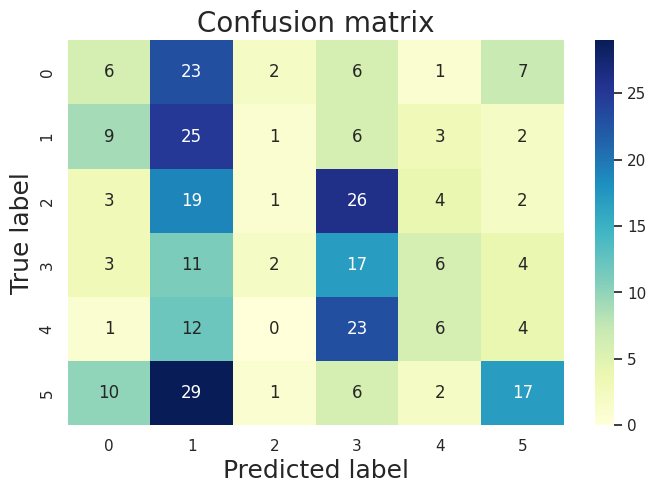

In [15]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)